In [1]:
# Étape 1 : Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

# Étape 2 : Chargement des données

# Charger ton fichier de features
features_df = pd.read_csv("../features/features_cartes_virtuelles.csv") 
print("features charge")

features charge


In [2]:
#-------------------- algorithme Isolation Forest---------

# Étape 3 : Normalisation des features (mettre les variables a la meme echelle)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_df)

print("normalisation reussi")

normalisation reussi


In [3]:
# Etape 4 : Application de l'Isolation Forest

# Initialisation du modèle (paramètres ajustables)
model = IsolationForest(
    contamination=0.1,      # % estimé d'anomalies
    n_estimators=50,        # nombre d’arbres dans la forêt
    random_state=42          # pour reproductibilité
)

# Entraînement du modèle
model.fit(X_scaled)

# Prédiction : 1 = normal, -1 = anomalie
features_df['anomalie'] = model.predict(X_scaled)



# Étape 5 : Réduction de dimension (PCA)

# On réduit les données à 2 dimensions pour pouvoir les afficher en 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

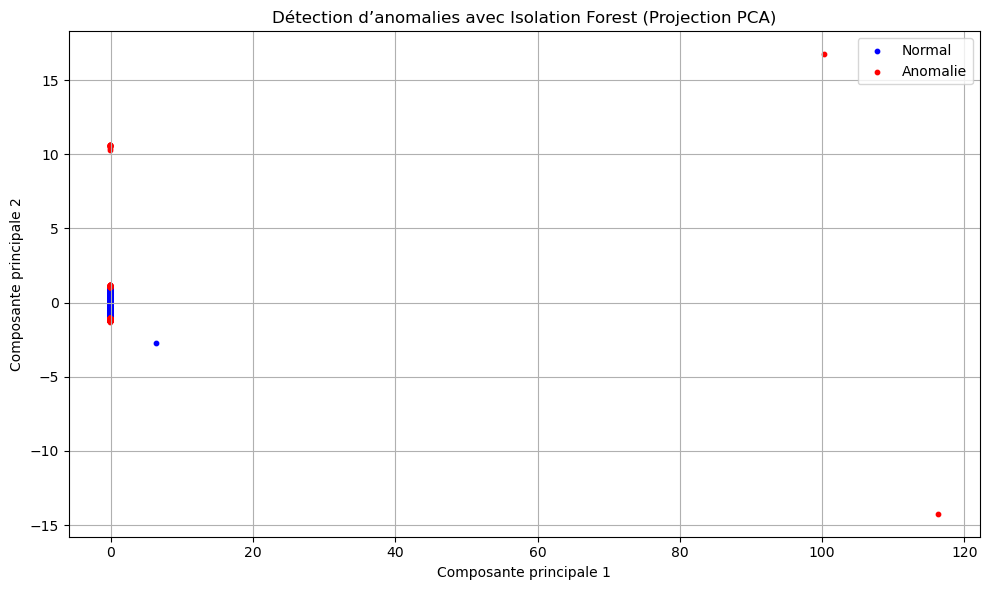

In [4]:
# Étape 6 : Visualisation avec matplotlib

# Création du graphe
plt.figure(figsize=(10, 6))

# Points normaux
plt.scatter(
    X_pca[features_df['anomalie'] == 1, 0], 
    X_pca[features_df['anomalie'] == 1, 1], 
    c='blue', label='Normal', s=10
)

# Points anormaux
plt.scatter(
    X_pca[features_df['anomalie'] == -1, 0], 
    X_pca[features_df['anomalie'] == -1, 1], 
    c='red', label='Anomalie', s=10
)

# Habillage du graphe
plt.title("Détection d’anomalies avec Isolation Forest (Projection PCA)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Affichage du graphe
plt.show()

In [5]:
# Etape 7 : Ajouter les prédictions au DataFrame original

# Ajout d'une colonne is_fraud : 1 pour fraude, 0 pour normal
features_df['is_fraud'] = [1 if x == -1 else 0 for x in model.predict(X_scaled)]

#. Afficher le nombre total de fraudes détectées
nombre_fraudes = features_df['is_fraud'].sum()
print(f"Nombre de fraudes détectées : {nombre_fraudes}")

# 3. Extraire les transactions suspectes
features_df_fraudes = features_df[features_df['is_fraud'] == 1]

# Sauvegarde (ajout de is_fraud au dataset)
features_df.to_csv("../features/features_cartes_virtuelles_isolation_forest_avec_fraude.csv", index=False)
print("Fichier enrichi avec is_fraud exporté.")

Nombre de fraudes détectées : 268
Fichier enrichi avec is_fraud exporté.


In [6]:
#rapport_de _fraude

# Nombre total de fraudes détectées
nb_fraude = features_df[features_df['is_fraud'] == 1].shape[0]
print(f"Nombre total d'utilisateurs suspects de fraude : {nb_fraude}")

# 1. Charger les données enrichies avec is_fraud
df_fraude = pd.read_csv("../features/features_cartes_virtuelles_isolation_forest_avec_fraude.csv")

# 2. Charger les utilisateurs bruts (avec leurs vrais noms)
user_df = pd.read_csv("../datasets/user.csv")

# 3. Re-normaliser les id bruts pour retrouver la correspondance avec les user_id normalisés
scaler = MinMaxScaler()
user_df['user_id_normalise'] = scaler.fit_transform(user_df[['id']])

# 4. Fusion entre les prédictions de fraude et les noms d’utilisateur
df_rapport = df_fraude.merge(user_df[['id', 'username', 'user_id_normalise']], left_on='user_id', right_on='user_id_normalise', how='left')

# 5. Fonction pour générer une description logique pour chaque fraude détectée
def generer_description(row):
    raisons = []
    if 'montant_total_paye' in row and row['montant_total_paye'] > 1_000_000:
        raisons.append("montant seuil depasse")
    if 'nb_trans_failed' in row and row['nb_trans_failed'] > 3:
        raisons.append("plusieurs échecs de transactions")
    if 'kyc_valide' in row and row['kyc_valide'] == 0:
        raisons.append("KYC non validé")

    
    return ", ".join(raisons) if raisons else "comportement suspect détecté par le modèle"

# 6. Application de la logique uniquement aux lignes is_fraud = 1
df_rapport['description'] = df_rapport.apply(
    lambda row: generer_description(row) if row['is_fraud'] == 1 else "", axis=1
)

# 7. Sélection des colonnes intéressantes pour le rapport
colonnes_affichage = ['id', 'username', 'is_fraud', 'description']
rapport_lisible = df_rapport[df_rapport['is_fraud'] == 1][colonnes_affichage]

# 8.suppression des lignes avec des valeurs manquantes (NaN)
rapport_lisible = rapport_lisible.dropna(subset=['username', 'id'])

#9. Convertir la colonne 'id' en int
rapport_lisible['id'] = rapport_lisible['id'].astype(int)

# 10. Affichage
print("Utilisateurs détectés comme fraudeurs :")
display(rapport_lisible)


Nombre total d'utilisateurs suspects de fraude : 268
Utilisateurs détectés comme fraudeurs :


,id,username,is_fraud,description
0,1,bruyan,1,"plusieurs échecs de transactions, KYC non validé"
41,63,Bertille Medjo,1,KYC non validé
58,80,Valantine ngewih Ayeah,1,KYC non validé
78,100,Mandaha tsomelou rodiane,1,KYC non validé
87,111,Kemte tchanegha lyn VANeLLE,1,KYC non validé
...,...,...,...,...
2671,2733,Th4m1s,1,KYC non validé
2672,2734,Th0m4s,1,KYC non validé
2674,2736,UGANDA,1,KYC non validé
2675,2737,Lomanga,1,KYC non validé


In [7]:
# 9. Export final
rapport_lisible.to_csv("../features/rapport_fraude_carte_virtuelle_isolation_forest.csv", index=False)
print("Exporté : rapport_fraude_carte_virtuelle_isolation_forest.csv")

Exporté : rapport_fraude_carte_virtuelle_isolation_forest.csv


C:\Users\NDL\AppData\Local\Temp\ipykernel_17812\3747865552.py:49: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_pca[y_pred == -1, 0], X_pca[y_pred == -1, 1],


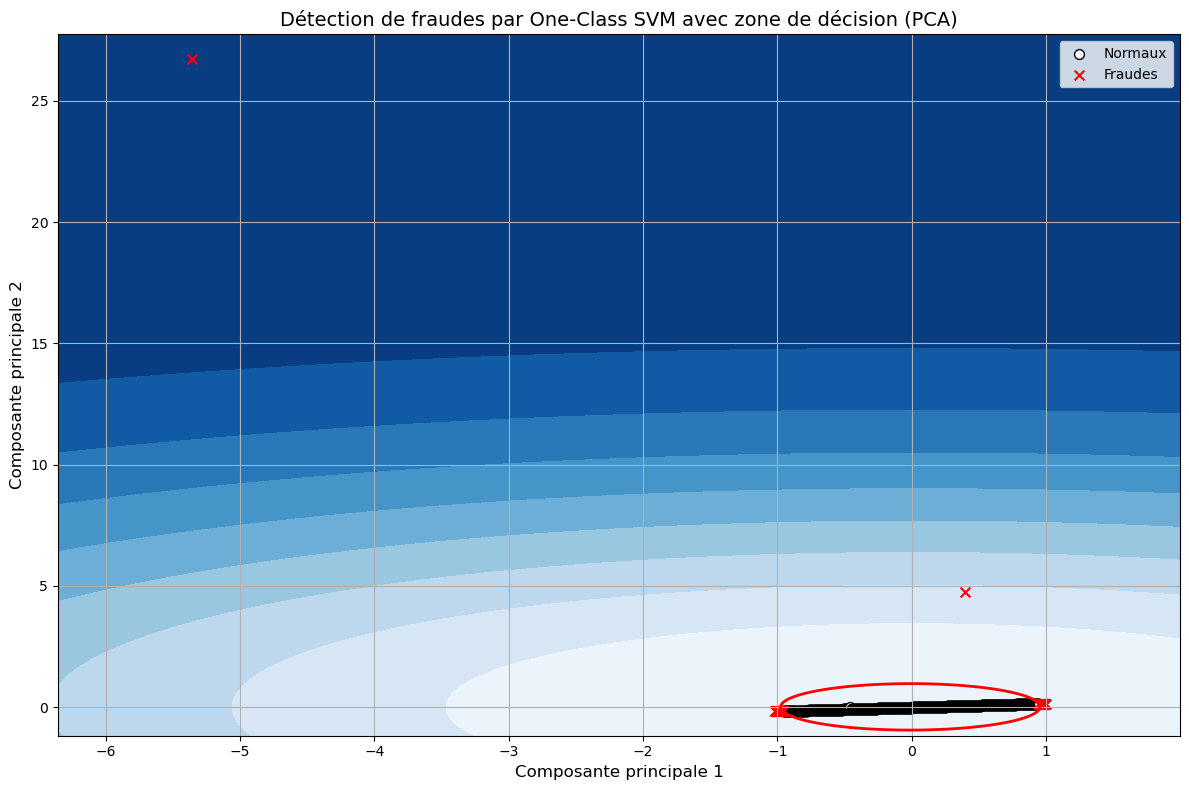

In [8]:
#--------------------------- algorithme SVM ----------------------------

# Importer les bibliothèques nécessaires
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Étape 1 : Chargement et préparation des données
features_df = pd.read_csv("../features/features_cartes_virtuelles.csv")

# Normalisation robuste
scaler = RobustScaler()
X_scaled = scaler.fit_transform(features_df)

# Réduction de dimension (2D) pour visualisation
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Étape 2 : Entraînement du modèle SVM
model = OneClassSVM(kernel='rbf', gamma=0.01, nu=0.05)
model.fit(X_pca)
y_pred = model.predict(X_pca)

# Étape 3 : Création de la grille de décision
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Calcul de la fonction de décision
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Étape 4 : Visualisation
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap=plt.cm.Blues_r)

# Courbe rouge de décision
plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')

# Points normaux (prédits 1)
plt.scatter(X_pca[y_pred == 1, 0], X_pca[y_pred == 1, 1],
            c='white', edgecolor='black', s=50, label="Normaux")

# Points frauduleux (prédits -1)
plt.scatter(X_pca[y_pred == -1, 0], X_pca[y_pred == -1, 1],
            c='red', edgecolor='black', marker='x', s=50, label="Fraudes")

# Mise en forme
plt.title("Détection de fraudes par One-Class SVM avec zone de décision (PCA)", fontsize=14)
plt.xlabel("Composante principale 1", fontsize=12)
plt.ylabel("Composante principale 2", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# Étape 1 : Ajouter les résultats bruts du modèle
features_df['anomalie_svm'] = y_pred  # 1 = normal, -1 = anomalie

# Étape 2 : Créer une colonne binaire plus lisible
features_df['is_fraud_svm'] = features_df['anomalie_svm'].apply(lambda x: 1 if x == -1 else 0)

# (Optionnel) Étape 3 : Ajouter une description textuelle lisible
features_df['fraud_status'] = features_df['is_fraud_svm'].apply(lambda x: "Fraude détectée" if x == 1 else "Normale")

#. Afficher le nombre total de fraudes détectées
nombre_fraudes = features_df['is_fraud_svm'].sum()
print(f"Nombre de fraudes détectées : {nombre_fraudes}")

# Sauvegarde (ajout de is_fraud au dataset)
features_df.to_csv("../features/features_cartes_virtuelles_SVM_avec_fraude.csv", index=False)
print("Fichier enrichi avec is_fraud exporté.")

Nombre de fraudes détectées : 135
Fichier enrichi avec is_fraud exporté.


In [10]:
# 9. rapport_de _fraude

# Nombre total de fraudes détectées
nb_fraude = features_df[features_df['is_fraud_svm'] == 1].shape[0]
print(f"Nombre total d'utilisateurs suspects de fraude : {nb_fraude}")

# a. Charger les données enrichies avec is_fraud
df_fraude = pd.read_csv("../features/features_cartes_virtuelles_SVM_avec_fraude.csv")

# b. Charger les utilisateurs bruts (avec leurs vrais noms)
user_df = pd.read_csv("../datasets/user.csv")

# c. Re-normaliser les id bruts pour retrouver la correspondance avec les user_id normalisés
scaler = MinMaxScaler()
user_df['user_id_normalise'] = scaler.fit_transform(user_df[['id']])

# d. Fusion entre les prédictions de fraude et les noms d’utilisateur
df_rapport = df_fraude.merge(user_df[['id', 'username', 'user_id_normalise']], left_on='user_id', right_on='user_id_normalise', how='left')

# e. Fonction pour générer une description logique pour chaque fraude détectée
def generer_description(row):
    raisons = []
    if 'montant_total_paye' in row and row['montant_total_paye'] > 1_000_000:
        raisons.append("montant seuil depasse")
    if 'nb_trans_failed' in row and row['nb_trans_failed'] > 3:
        raisons.append("plusieurs échecs de transactions")
    if 'kyc_valide' in row and row['kyc_valide'] == 0:
        raisons.append("KYC non validé")

    
    return ", ".join(raisons) if raisons else "comportement suspect détecté par le modèle"

# f. Application de la logique uniquement aux lignes is_fraud = 1
df_rapport['description'] = df_rapport.apply(
    lambda row: generer_description(row) if row['is_fraud_svm'] == 1 else "", axis=1
)

# g. Sélection des colonnes intéressantes pour le rapport
colonnes_affichage = ['id', 'username', 'is_fraud_svm', 'description']
rapport_lisible = df_rapport[df_rapport['is_fraud_svm'] == 1][colonnes_affichage]

# h.suppression des lignes avec des valeurs manquantes (NaN)
rapport_lisible = rapport_lisible.dropna(subset=['username', 'id'])

# i. Convertir la colonne 'id' en int
rapport_lisible['id'] = rapport_lisible['id'].astype(int)

# j. Affichage
print("Utilisateurs détectés comme fraudeurs :")
display(rapport_lisible)



Nombre total d'utilisateurs suspects de fraude : 135
Utilisateurs détectés comme fraudeurs :


,id,username,is_fraud_svm,description
0,1,bruyan,1,"plusieurs échecs de transactions, KYC non vali..."
41,63,Bertille Medjo,1,"KYC non validé, compte inactif depuis longtemps"
58,80,Valantine ngewih Ayeah,1,"KYC non validé, compte inactif depuis longtemps"
2613,2675,GAFFARSAVADOGO,1,"KYC non validé, compte inactif depuis longtemps"
2614,2676,Baracuda,1,"KYC non validé, compte inactif depuis longtemps"
2615,2677,Coulibaly n'golo,1,"KYC non validé, compte inactif depuis longtemps"
2616,2678,cd7191729@gmail.com,1,"KYC non validé, compte inactif depuis longtemps"
2617,2679,Mohamed,1,compte inactif depuis longtemps
2618,2680,Maman Nouri Manzo,1,"KYC non validé, compte inactif depuis longtemps"
2619,2681,Patrick,1,"KYC non validé, compte inactif depuis longtemps"


In [62]:
# k. Export final
rapport_lisible.to_csv("../features/rapport_fraude_carte_virtuelle_SVM.csv", index=False)
print("Exporté : rapport_fraude_carte_virtuelle_SVM.csv")

Exporté : rapport_fraude_carte_virtuelle_SVM.csv


In [63]:
#--------- alogorithme k-means --------

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [64]:
# 2. Appliquer K-Means

features_df = pd.read_csv("../features/features_cartes_virtuelles.csv") 

# filtrage des colonnes numeriques
X = features_df.select_dtypes(include=['int64', 'float64'])

k = 3  # Nombre de clusters
kmeans = KMeans(n_clusters=k, random_state=42)
features_df['cluster'] = kmeans.fit_predict(X)

In [65]:
# 3. Afficher les centroïdes (caractéristiques moyennes par groupe)

print("----- Centroïdes des clusters -----")
centroides = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
print(centroides)

----- Centroïdes des clusters -----
    user_id    nb_wallets  balance_moyen   balance_max  nb_trans_total  \
0  0.260887 -3.252607e-17   1.924459e-18  1.924459e-18   -2.862294e-17   
1  0.000000  1.000000e+00   1.887274e-01  1.887274e-01    4.000000e+00   
2  0.752890  1.486989e-03   1.403178e-04  1.403178e-04    4.460967e-03   

   nb_trans_failed  taux_echec_trans  nb_paiements  montant_total_paye  \
0    -6.505213e-17     -1.626303e-18 -2.862294e-17       -6.288373e-17   
1     4.000000e+00      1.000000e+00  4.000000e+00        3.999999e+00   
2     1.486989e-03      2.478315e-04  4.460967e-03        4.460965e-03   

   nb_transferts_30j  nb_ips_diff  nb_modifications_wallet  age_compte_jours  \
0                0.0     0.000751            -1.370432e-16           20171.0   
1                0.0     2.000000             2.600000e+01           20171.0   
2                0.0     0.000743             7.434944e-04           20171.0   

   delai_derniere_op    kyc_valide  
0           

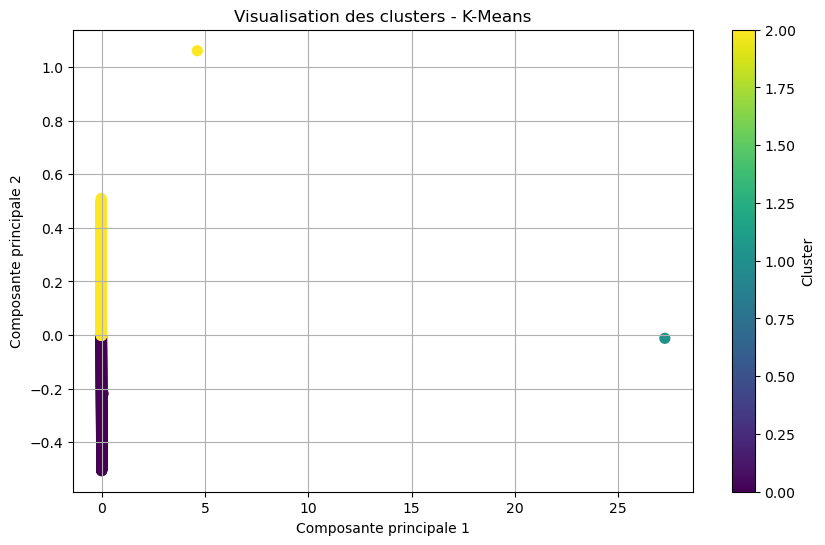

In [66]:
# 4. Visualisation des clusters avec PCA (réduction à 2 dimensions)
pca = PCA(n_components=2)
X_reduit = pca.fit_transform(X)

plt.figure(figsize=(10,6))
plt.scatter(X_reduit[:, 0], X_reduit[:, 1], c=features_df['cluster'], cmap='viridis', s=50)
plt.title("Visualisation des clusters - K-Means")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.colorbar(label="Cluster")
plt.show()

In [67]:
# 5. Sauvegarder le DataFrame avec les clusters
features_df.to_csv("../features/features_cartes_virtuelles_avec_clusters.csv", index=False)
print("Fichier exporté : features_cartes_virtuelles_avec_clusters.csv")

Fichier exporté : features_cartes_virtuelles_avec_clusters.csv


In [68]:
#fusion des resultats clustering + detection de fraudes

# 1. Charger les fichiers
clusters_df = pd.read_csv("../features/features_cartes_virtuelles_avec_clusters.csv")  # Contient la colonne 'cluster'
isoforest_df = pd.read_csv("../features/features_cartes_virtuelles_isolation_forest_avec_fraude.csv")  # Contient 'is_fraud'
svm_df = pd.read_csv("../features/features_cartes_virtuelles_SVM_avec_fraude.csv")  # Contient 'is_fraud'

# 2. Renommer les colonnes pour éviter les conflits
isoforest_df = isoforest_df.rename(columns={"is_fraud": "is_fraud_isolation"})
svm_df = svm_df.rename(columns={"is_fraud_svm": "is_fraud_svm"})

# 3. Fusionner les DataFrames sur l’index (chaque ligne = un utilisateur identique)
fusion_temp = pd.merge(clusters_df, isoforest_df[["is_fraud_isolation"]], left_index=True, right_index=True)
fusion_finale = pd.merge(fusion_temp, svm_df[["is_fraud_svm"]], left_index=True, right_index=True)

# 4. Enregistrer le fichier fusionné
fusion_finale.to_csv("../features/features_clusters_isoforest_svm.csv", index=False)
print("Fichier de fusion créé avec succès : features_clusters_isoforest_svm.csv")

# 5. Aperçu du résultat
print(fusion_finale.head())

Fichier de fusion créé avec succès : features_clusters_isoforest_svm.csv
    user_id  nb_wallets  balance_moyen  balance_max  nb_trans_total  \
0  0.000000         1.0       0.188727     0.188727             4.0   
1  0.001827         0.0       0.000000     0.000000             0.0   
2  0.002558         0.0       0.000000     0.000000             0.0   
3  0.004750         0.0       0.000000     0.000000             0.0   
4  0.005115         0.0       0.000000     0.000000             0.0   

   nb_trans_failed  taux_echec_trans  nb_paiements  montant_total_paye  \
0              4.0               1.0           4.0            3.999999   
1              0.0               0.0           0.0            0.000000   
2              0.0               0.0           0.0            0.000000   
3              0.0               0.0           0.0            0.000000   
4              0.0               0.0           0.0            0.000000   

   nb_transferts_30j  nb_ips_diff  nb_modifications_wal

In [69]:
#rapport clusters

# 1. Charger le fichier fusionné
# Ce fichier doit contenir les colonnes : cluster, is_fraud_isolation, is_fraud_svm
df = pd.read_csv("../features/features_clusters_isoforest_svm.csv")

# 2. Grouper les utilisateurs par cluster et compter
rapport = df.groupby("cluster").agg(
    total_utilisateurs=("cluster", "count"),                  # Total d'utilisateurs dans chaque cluster
    nb_fraudes_isoforest=("is_fraud_isolation", "sum"),       # Total de fraudes détectées par Isolation Forest
    nb_fraudes_svm=("is_fraud_svm", "sum")                    # Total de fraudes détectées par SVM
)

# 3. Calculer les taux de fraude (%) par méthode
rapport["taux_fraude_isoforest (%)"] = (
    rapport["nb_fraudes_isoforest"] / rapport["total_utilisateurs"] * 100
).round(2)

rapport["taux_fraude_svm (%)"] = (
    rapport["nb_fraudes_svm"] / rapport["total_utilisateurs"] * 100
).round(2)

# 4. Afficher le rapport
print("=== Rapport de Fraude par Cluster ===")
print(rapport)

# 5. Sauvegarder le rapport en CSV si besoin
rapport.to_csv("../features/rapport_fraude_par_cluster.csv", index=True)
print("\nRapport exporté : rapport_fraude_par_cluster.csv")

=== Rapport de Fraude par Cluster ===
         total_utilisateurs  nb_fraudes_isoforest  nb_fraudes_svm  \
cluster                                                             
0                      1332                   175              67   
1                         1                     1               1   
2                      1344                    92              67   

         taux_fraude_isoforest (%)  taux_fraude_svm (%)  
cluster                                                  
0                            13.14                 5.03  
1                           100.00               100.00  
2                             6.85                 4.99  

Rapport exporté : rapport_fraude_par_cluster.csv


In [70]:
clusters_df = pd.read_csv("../features/features_cartes_virtuelles_avec_clusters.csv")
isoforest_df = pd.read_csv("../features/rapport_fraude_carte_virtuelle_isolation_forest.csv")
svm_df = pd.read_csv("../features/rapport_fraude_carte_virtuelle_SVM.csv")

print(clusters_df)
print(isoforest_df)
print(svm_df)

       user_id  nb_wallets  balance_moyen  balance_max  nb_trans_total  \
0     0.000000         1.0       0.188727     0.188727             4.0   
1     0.001827         0.0       0.000000     0.000000             0.0   
2     0.002558         0.0       0.000000     0.000000             0.0   
3     0.004750         0.0       0.000000     0.000000             0.0   
4     0.005115         0.0       0.000000     0.000000             0.0   
...        ...         ...            ...          ...             ...   
2672  0.998539         0.0       0.000000     0.000000             0.0   
2673  0.998904         0.0       0.000000     0.000000             0.0   
2674  0.999269         0.0       0.000000     0.000000             0.0   
2675  0.999635         0.0       0.000000     0.000000             0.0   
2676  1.000000         2.0       0.188727     0.188727             6.0   

      nb_trans_failed  taux_echec_trans  nb_paiements  montant_total_paye  \
0                 4.0          1.0

In [85]:

# Étape 1 : Chargement des fichiers CSV
# -------------------------------------
# Chargement des données contenant les informations de clustering
clusters_df = pd.read_csv("../features/features_cartes_virtuelles_avec_clusters.csv")

# Chargement des résultats du modèle Isolation Forest
isoforest_df = pd.read_csv("../features/rapport_fraude_carte_virtuelle_isolation_forest.csv")

# Chargement des résultats du modèle SVM
svm_df = pd.read_csv("../features/rapport_fraude_carte_virtuelle_SVM.csv")

#chargement du fichier brut User

users_df = pd.read_csv("../datasets/user.csv")

# Étape 2 : Harmonisation des colonnes pour la fusion
# ---------------------------------------------------
# Renommage de la colonne 'user_id' en 'id' pour uniformiser les clés de fusion
clusters_df = clusters_df.rename(columns={"user_id": "id"}).astype({"id": int})

# Conversion de id pretraites en id brut
clusters_df['id'] = range(1, len(clusters_df) + 1)

# Renommage des colonnes de résultats pour éviter les conflits lors de la fusion
isoforest_df = isoforest_df.rename(columns={"is_fraud": "is_fraud_isolation"})
svm_df = svm_df.rename(columns={"is_fraud_svm": "is_fraud_svm"})

# Étape 3 : Fusion des données

# Fusion clusters + Isolation Forest
fusion_temp = pd.merge(clusters_df, isoforest_df[['id', 'is_fraud_isolation', 'description']], on='id', how='left')

# Fusion avec SVM
fusion_finale = pd.merge(fusion_temp, svm_df[['id', 'is_fraud_svm']], on='id', how='left')

# Fusion avec noms d'utilisateur
rapport_avec_noms = pd.merge(fusion_finale, users_df[['id', 'username']], on='id', how='left')

# === ÉTAPE 6 : Réorganiser les colonnes dans l'ordre souhaité ===
colonnes_ordre = ['id', 'username', 'cluster', 'is_fraud_isolation', 'is_fraud_svm', 'description']
rapport_avec_noms = rapport_avec_noms[colonnes_ordre]

# Étape 7 : Supprimer les lignes avec des valeurs manquantes
rapport_propre = rapport_avec_noms.dropna()

# Afficher un aperçu du rapport nettoyé
print("Aperçu du rapport sans valeurs manquantes :")
display(rapport_propre.head())
display(rapport_avec_noms)
# Étape 8 : Exporter le rapport propre
chemin_non_propre = "../features/rapport_fraude_clusters_avec_noms.csv"
chemin_propre = "../features/rapport_fraude_clusters_avec_noms_sans_nan.csv"
rapport_propre.to_csv(chemin_propre, index=False)
rapport_avpropre.to_csv(chemin_propre, index=False)
print(f"\nRapport propre exporté avec succès : {chemin_propre}")
print(f"\nRapport propre exporté avec succès : {chemin_non_propre}")

Aperçu du rapport sans valeurs manquantes :


,id,username,cluster,is_fraud_isolation,is_fraud_svm,description
0,1,bruyan,1,1.0,1.0,"plusieurs échecs de transactions, KYC non vali..."
62,63,Bertille Medjo,0,1.0,1.0,"KYC non validé, compte inactif depuis longtemps"
79,80,Valantine ngewih Ayeah,0,1.0,1.0,"KYC non validé, compte inactif depuis longtemps"
2674,2675,GAFFARSAVADOGO,2,1.0,1.0,"KYC non validé, compte inactif depuis longtemps"
2675,2676,Baracuda,2,1.0,1.0,"KYC non validé, compte inactif depuis longtemps"


,id,username,cluster,is_fraud_isolation,is_fraud_svm,description
0,1,bruyan,1,1.0,1.0,"plusieurs échecs de transactions, KYC non vali..."
1,2,NaN,0,NaN,NaN,NaN
2,3,NaN,0,NaN,NaN,NaN
3,4,NaN,0,NaN,NaN,NaN
4,5,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...
2672,2673,lola242,2,NaN,NaN,NaN
2673,2674,TSHOUONGANG GASMAN DURAND,2,NaN,NaN,NaN
2674,2675,GAFFARSAVADOGO,2,1.0,1.0,"KYC non validé, compte inactif depuis longtemps"
2675,2676,Baracuda,2,1.0,1.0,"KYC non validé, compte inactif depuis longtemps"



Rapport propre exporté avec succès : ../features/rapport_fraude_clusters_avec_noms_sans_nan.csv

Rapport propre exporté avec succès : ../features/rapport_fraude_avec_noms.csv
